In [29]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['figure.dpi'] = 200

# Generating statistics relevant for RRS genotyping design

The goal is to identify relevant statistics that would allow us to assess if a species/genome is suitable for a designed reduced representation. I want to determine if the restriction enzyme cuts fragments that are suitable for adaptor PCR-based filtration and that the skew of the cuts are not beyond the expected average of a 4-6 bp cutter. 

In [30]:
# Helper class
from collections import defaultdict

class reSites:
    
    def __init__(self, fai, refile):
        # initiation attributes
        self.chrlens = dict()
        self.reDict = defaultdict(dict)
        self.reEnzymes = set()
        self._loadChrLens(fai)
        self._loadREData(refile)
        
        
        # calculation attributes
        self.reFragLens = defaultdict(list)
        self.reFragCoords = defaultdict(list)
        
    def _loadChrLens(self, fai):
        with open(fai, 'r') as input:
            for l in input:
                s = l.rstrip().split()
                self.chrlens[s[0]] = int(s[1])
    
    def _loadREData(self, refile):
        with open(refile, 'r') as input:
            for l in input:
                s = l.rstrip().split("\t")
                s[2] = s[2].replace("[", "").replace("]", "").replace(',', "")
                v = s[2].split()
                self.reEnzymes.add(s[1])
                # Convert all values to int for easier comparisons later
                self.reDict[s[0]][s[1]] = list(map(lambda x: int(x), v))
    
    def calcFragments(self):
        for r in self.reEnzymes:            
            for c, l in self.chrlens.items():
                last = 0
                for bp in self.reDict[c][r]:
                    fglen = bp - last
                    self.reFragLens[r].append(fglen)
                    self.reFragCoords[r].append(f'{c}\t{last + 1}\t{bp}')
                    last = bp
                fglen = l - last
                self.reFragLens[r].append(fglen)
                self.reFragCoords[r].append(f'{c}\t{last + 1}\t{l}')
                
    def fragLensToDF(self):
        hdict = defaultdict(list)
        for re, ls in self.reFragLens.items():
            for l in ls:
                hdict["Enzyme"].append(re)
                hdict["Length"].append(l)
        return pd.DataFrame(hdict, columns = ["Enzyme", "Length"])

---
## Loading data

OK, I have a decent number of helper functions written, let's load the files and then start generating some general plots and statistics.

In [31]:
from pathlib import Path
baseURL = r"C:\Users\Derek.Bickhart\OneDrive - Hendrix Genetics\Documents\work_data\insects\blackSoldierFly\reduced_representation\\"

worker = reSites(Path(baseURL + 'GCF_905115235.1_iHerIll2.2.curated.20191125_genomic.fna.fai'), Path(baseURL + 'restriction_sites.tab'))   

print("Loaded")

Loaded


---
## Diagnostic plots of fragment lengths

OK, let's see the distributions of fragment lengths first. We will need to do a log transform to actually visualize the data, but then we will bound the viable fragments (between 300 and 500 bp) with red bars for better visualization.

In [32]:
worker.calcFragments()

ldf = worker.fragLensToDF()

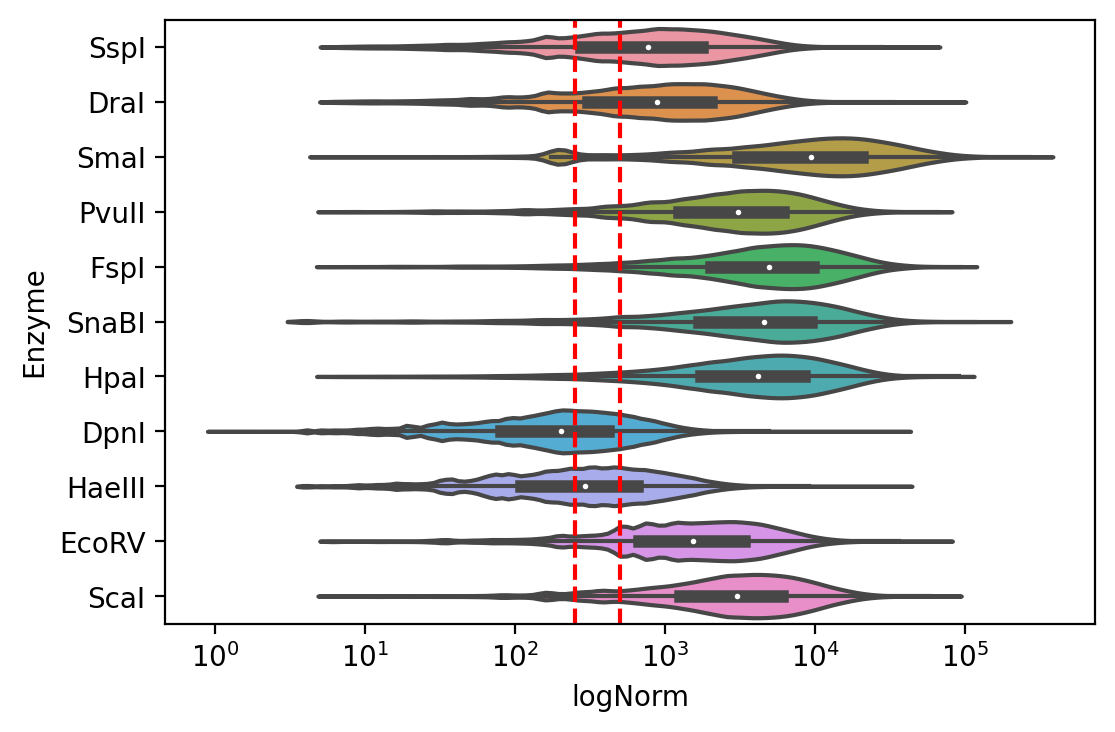

In [33]:
from matplotlib import ticker as mticker
ldf['logNorm'] = np.log10(ldf['Length'])

ax = plt.gca()
sns.violinplot(data=ldf, x="logNorm", y="Enzyme")
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.axvline(x = 2.4, color = 'r', ls = '--')
plt.axvline(x = 2.7, color = 'r', ls = '--')
plt.show()

---
Now let's see how much of the actual genome assembly is covered by fragments of that length. I will generate a cummulative length plot here. 

[(0.0, 1004948288.0)]

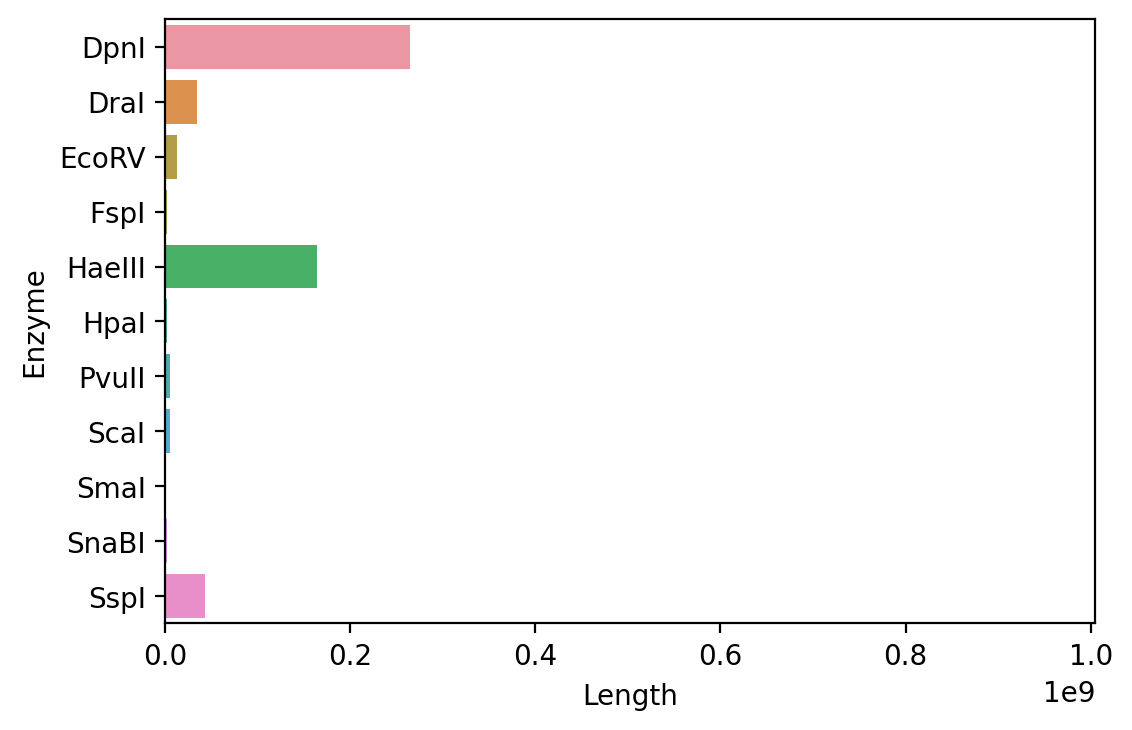

In [34]:
fdf = ldf[ldf['logNorm'].between(2.4, 2.7, inclusive= "both")]
sums = fdf.groupby(['Enzyme'], as_index=False).agg({"Length":"sum", "logNorm": "sum"})
#print(sums)

genomeLen = 0
for k, i in worker.chrlens.items():
    genomeLen += i

ax = plt.gca()
sns.barplot(data=sums, x="Length", y="Enzyme")
ax.set(xlim=(0, genomeLen))

---

So far, both SspI and DraI appear to be in the "Goldilocks" zone, where they cover a lesser, but more reasonable percentage of the genome sequence, whereas DpnI and HaeIII have a distribution of fragments that would cover a larger percentage of the genome within this size range. 

---
## Printing out BED coordinates

OK, for my final trick, I am going to print out the coordinates of the cut sites for the four enzymes I mentioned above. Then we should intersect them with the regions indicated by the Fst screen that Katrijn and Elena conducted. 

In [35]:
for r, coords in worker.reFragCoords.items():
    with open(Path(baseURL + f'{r}_blackSFly_cuts.bed'), 'w') as output:
        for c in coords:
            output.write(c + '\n')
    print(f'Wrote out file: {r}_blackSFly_cuts.bed')

Wrote out file: SspI_blackSFly_cuts.bed
Wrote out file: DraI_blackSFly_cuts.bed
Wrote out file: SmaI_blackSFly_cuts.bed
Wrote out file: PvuII_blackSFly_cuts.bed
Wrote out file: FspI_blackSFly_cuts.bed
Wrote out file: SnaBI_blackSFly_cuts.bed
Wrote out file: HpaI_blackSFly_cuts.bed
Wrote out file: DpnI_blackSFly_cuts.bed
Wrote out file: HaeIII_blackSFly_cuts.bed
Wrote out file: EcoRV_blackSFly_cuts.bed
Wrote out file: ScaI_blackSFly_cuts.bed


---
## Fst window analysis and genome distribution

OK, the next test is to see how well each single cut experiment intersects with identified Fst windows from Elena's analysis, and to see how each of the target cuts distribute across the Turkey genome.

I will select the four enzymes that have the best chances of reducing the size of the genome without greatly compromising predicted quality.

In [55]:
# Helper classes and functions
from matplotlib.collections import BrokenBarHCollection

# Helper function to get chromosome names and lengths for the ideogram plot
def get_chromosomes_names(input):
    list_chromosomes = []
    list_length = []
    with open(input, 'r') as fai:
        for l in fai:
            segs = l.rstrip().split()
            list_chromosomes.append(segs[0])
            list_length.append(int(segs[1]))
    return list_chromosomes, list_length

# Helper function to get the matplotlib schema for plotting the chromosomes and window locations
def chromosome_collections(df, y_positions, height,  **kwargs):
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']
        
class bed:        
    def __init__(self, chrom, start, end):
        self.chrom = chrom
        self.start = start
        self.end = end
        self.counter = defaultdict(int)

    def intersects(self, bed):
        if self.chrom == bed.chrom:
            if self.start < bed.end and self.end > bed.start:
                return True
        return False

    def intersectCoord (self, chrom, start, end):
        if self.chrom == chrom:
            if self.start < end and self.end > start:
                return True
        return False

class FstWindows:
    
        
    def __init__(self, fstfile, winsize, fstcutoff = 0.20):
        self.beds = defaultdict(list)
        self.winsize = winsize
        self.fstcutoff = fstcutoff
        self.totalFstWins = 0
        
        self._loadFstFile(fstfile)
        
    def _loadFstFile(self, fstfile):
        with open(fstfile, 'r') as input:
            for l in input:
                s = l.rstrip().split()
                fst = float(s[7])
                start = int(s[1])
                if fst > self.fstcutoff:
                    self.totalFstWins += 1
                    self.beds[s[0]].append(bed(s[0], start, start + self.winsize))
                    
                    
    def intersectCoords(self, bedfile, rename, minsize, maxsize):
        with open(bedfile, 'r') as input:
            for l in input:
                s = l.rstrip().split()
                start = int(s[1])
                end = int(s[2])
                length = end - start
                if length >= minsize and length <= maxsize:
                    for i in self.beds[s[0]]:
                        if i.intersectCoord(s[0], start, end):
                            i.counter[rename] += 1
                            break # Only works if the smaller windows only intersect once, but saves time
    
    def intersectedCoordsToDF(self, rename):
        gtable = defaultdict(list)
        for k, l in self.beds.items():
            for i in l:
                if i.counter[rename] > 0:
                    gtable['chrom'].append(i.chrom)
                    gtable['start'].append(i.start)
                    gtable['end'].append(i.end)
                    gtable['name'].append(rename)
                    gtable['value'].append(i.counter[rename])
                    gtable['colors'].append('#2B0C1C')
        return pd.DataFrame(gtable)
    
    def plotWinCoords(self, faifile, gtable):
        chrom_height = 0.1
        chrom_spacing = 0.6
        gene_height = 0.4
        gene_padding = 0.1
        
        # organizing chromosomes
        list_chromosomes, list_length = get_chromosomes_names(faifile)
        chr_assoc = {k : v for k, v in zip(list_chromosomes, list_length)}
        list_chromosomes = [x for x, j in sorted(chr_assoc.items(), key=lambda item: item[1], reverse=True)]
        chromosome_list = list_chromosomes[:15]
        list_length = [v for k, v in sorted(chr_assoc.items(), key=lambda item: item[1], reverse=True)]
        chromosome_size = list_length[:15]
        
        # Keeping track of y positions for chromosomes
        ybase = 0
        chrom_ybase = {}
        gene_ybase = {}
        chrom_centers = {}
        
        # Need to iterate in reverse here for the plot
        for chrom in chromosome_list[::-1]:
            chrom_ybase[chrom] = ybase
            chrom_centers[chrom] = ybase + chrom_height / 2.
            gene_ybase[chrom] = ybase - gene_height - gene_padding
            ybase += chrom_height + chrom_spacing
            
        # Ideogram data frame    
        ideo = pd.DataFrame({'chrom' : chromosome_list,
                            'start' : [0 for x in range(len(chromosome_list))],
                            'width' : chromosome_size,
                            'colors': ['#bd2309' for x in range(len(chromosome_list))]})
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Using the helper function to add Hbar plots to the figure
        for collection in chromosome_collections(ideo, chrom_ybase, chrom_height):
            ax.add_collection(collection)
            
        for collection in chromosome_collections(
            gtable, gene_ybase, gene_height, alpha=0.5, linewidths=0
        ):
            ax.add_collection(collection)
            
        # Axes tweaking
        ax.set_yticks([chrom_centers[i] for i in chromosome_list])
        ax.set_yticklabels(chromosome_list)
        ax.axis('tight')
        plt.show()

In [56]:
# Processing the significant single cutters
# Gene dataframes
geneDFs = dict()
FstWorker = FstWindows(Path(baseURL + 'HerIll_fb_window10k_step5k_mcf01.fst'), 5000)

for i in ['DraI', 'DpnI', 'HaeIII', 'SspI']:
    FstWorker.intersectCoords(Path(baseURL + f'{i}_blackSFly_cuts.bed'), i, 300, 500)

    geneDFs[i] = FstWorker.intersectedCoordsToDF(i)
    uniqueChrs = geneDFs[i]['chrom'].unique()

    print(f'For {i} found {geneDFs[i].shape[0]} windows and {uniqueChrs} out of {FstWorker.totalFstWins} Fst wins')

For DraI found 999 windows and ['NC_051849.1' 'NC_051850.1' 'NC_051851.1' 'NC_051852.1' 'NC_051853.1'
 'NC_051854.1'] out of 3689 Fst wins
For DpnI found 3467 windows and ['NC_051849.1' 'NC_051850.1' 'NC_051851.1' 'NC_051852.1' 'NC_051853.1'
 'NC_051854.1'] out of 3689 Fst wins
For HaeIII found 2981 windows and ['NC_051849.1' 'NC_051850.1' 'NC_051851.1' 'NC_051852.1' 'NC_051853.1'
 'NC_051854.1'] out of 3689 Fst wins
For SspI found 1172 windows and ['NC_051849.1' 'NC_051850.1' 'NC_051851.1' 'NC_051852.1' 'NC_051854.1'] out of 3689 Fst wins


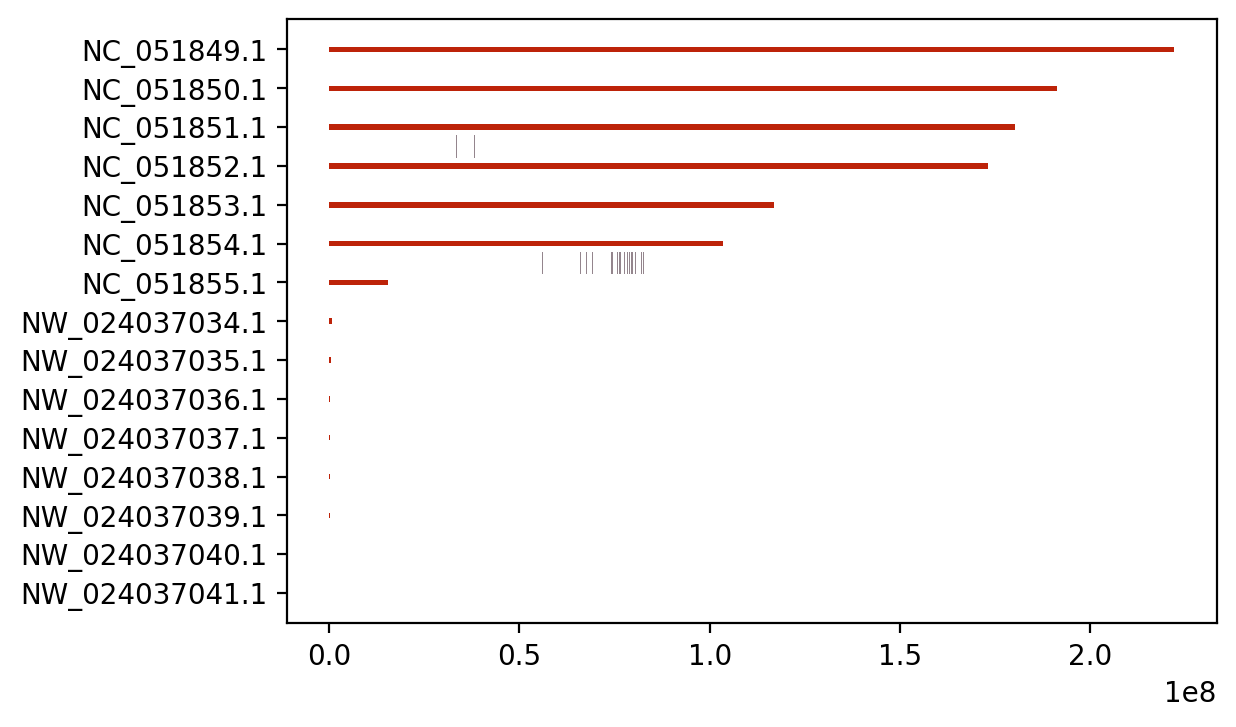

In [57]:
FstWorker.plotWinCoords(Path(baseURL + 'GCF_905115235.1_iHerIll2.2.curated.20191125_genomic.fna.fai'), geneDFs['DraI'])

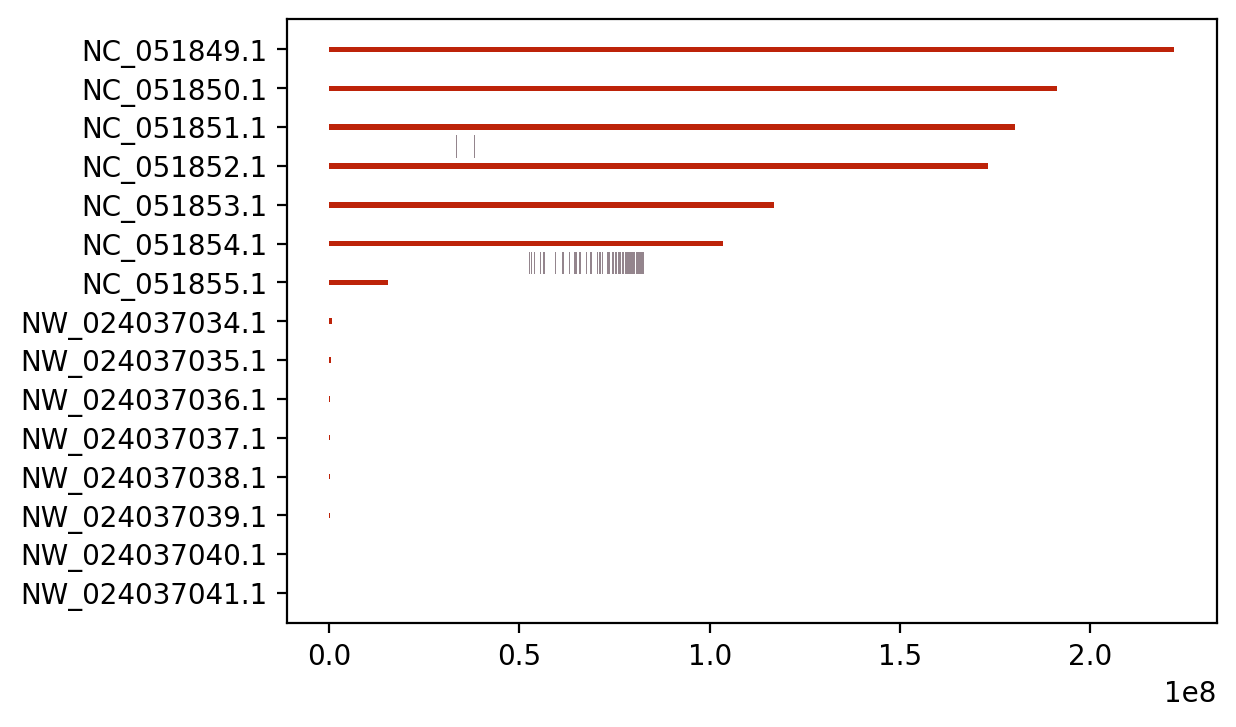

In [58]:
FstWorker.plotWinCoords(Path(baseURL + 'GCF_905115235.1_iHerIll2.2.curated.20191125_genomic.fna.fai'), geneDFs['HaeIII'])